In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

json_filename = 'reviews_cleaned.json'
reviews_df = pd.read_json(json_filename, orient='records', lines=True)
pd.set_option('display.max_columns', 999)
reviews_df.head()

,review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,textblob_sentiment,log_playtime_forever,log_playtime_at_review,log_playtime_last_two_weeks,normalized_playtime_forever,normalized_playtime_at_review,normalized_playtime_last_two_weeks,playtime_ratio,days_from_last_played_time,review_length,review_word_count,engagement_score,playtime_category,reviewer_experience,vader_sentiment,cleaned_review_tokens,review_tokens_no_stopwords,cleaned_reviews_NS,retention_score,retention_score_scaled
0,This game is very realistic and is super fun! ...,1,1,0,0.000000,0,1,0,514,514,167,1703564483000,0.137000,6.244167,5.123964,6.244167,-0.613314,-0.834628,3.950013,0.324903,17,80,16,1,High,Veteran,0.8830,"[this, game, is, very, realistic, and, is, sup...","[realistic, super, fun, highly, recommend, giv...",realistic super fun highly recommend give go,0.534623,0.667210
1,I've been having too much fun playing it. Keep...,1,1,0,0.000000,0,1,0,154,154,154,1703538758000,0.500000,5.043425,5.043425,5.043425,-1.279696,-0.884405,3.138292,1.000000,17,63,13,1,Medium,Newbie,0.7906,"[ive, been, having, too, much, fun, playing, i...","[ive, much, fun, playing, keep, good, work]",ive much fun playing keep good work,0.431025,0.593137
2,"A good, and I mean good, hacking simulator for...",1,3,0,0.543568,0,1,0,21,21,17,1703529507000,0.259430,3.091042,2.890372,3.091042,-2.363219,-2.215108,1.818448,0.809524,17,892,157,3,Low,Experienced,0.7269,"[a, good, and, i, mean, good, hacking, simulat...","[good, mean, good, hacking, simulator, underst...",good mean good hacking simulator understanding...,0.234024,0.452282
3,This is an amazingly realistic hacking simulat...,1,3,0,0.543568,0,1,0,46,46,35,1703529325000,0.405167,3.850148,3.583519,3.850148,-1.941935,-1.786706,2.331616,0.760870,17,419,71,3,Low,Veteran,0.9191,"[this, is, an, amazingly, realistic, hacking, ...","[amazingly, realistic, hacking, simulator, sim...",amazingly realistic hacking simulator simulate...,0.338357,0.526880
4,As a security specialist of 20+ years you're d...,1,33,0,0.808946,0,1,0,410,410,181,1703563314000,0.650000,6.018593,5.204007,6.018593,-0.738502,-0.785157,3.797521,0.441463,17,181,34,33,Medium,Veteran,0.8853,"[as, a, security, specialist, of, years, youre...","[security, specialist, years, youre, awesome, ...",security specialist years youre awesome job sh...,0.540351,0.671305


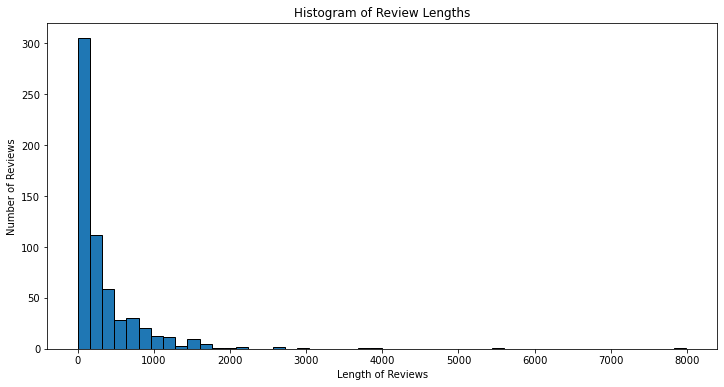

In [2]:
# Plotting the histogram of review lengths
plt.figure(figsize=(12, 6))
plt.hist(reviews_df['review_length'], bins=50, edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Number of Reviews')
plt.show()

In [3]:
# Processing text and preparing word embeddings using a pre-trained GloVe model
from tensorflow.keras.preprocessing.text import Tokenizer

# Initializing and fit the tokenizer
tokenizer = Tokenizer(num_words=5000)        # Top 5000 words based on frequency
tokenizer.fit_on_texts(reviews_df['review']) # Converting review into a sequence of integers

# Loading GloVe embeddings
embeddings_index = {}
with open('glove/glove.twitter.27B.200d.txt', encoding='utf8') as f: # Using twitter text data with 200 dimesions
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Preparing the embedding matrix
embedding_dim = 200  #  Matching the dimension of the GloVe embeddings file 
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
a
# Text Preprocessing
max_review_length = 2000  # Capture most reviews (from histogram of reviews)
review_sequences = tokenizer.texts_to_sequences(reviews_df['review'])
review_padded = pad_sequences(review_sequences, maxlen=max_review_length)

# One-hot encode categorical data
encoder = OneHotEncoder(sparse=False)
categorical_data = encoder.fit_transform(reviews_df[['playtime_category', 'reviewer_experience']])

# Scale numerical features
scaler = StandardScaler()
numerical_data = scaler.fit_transform(reviews_df[[# Playtime features
                                                  'normalized_playtime_forever', 
                                                  'normalized_playtime_last_two_weeks', 
                                                  'playtime_ratio', 
                                                  'days_from_last_played_time',
    
                                                  # Community Engagement features
                                                  'voted_up', 
                                                  'votes_up', 
                                                  'votes_funny',
                                                  'comment_count', 
                                                  'weighted_vote_score',
                                                  'engagement_score',
                                                  'textblob_sentiment', 
                                                  'vader_sentiment', 
    
                                                  # Purchase behaviour features
                                                  'steam_purchase', 
                                                  'received_for_free', 
    
                                                  # Review features
                                                  'review_length', 
                                                  'review_word_count'
    ]])

# Split the data
X_combined = np.hstack((categorical_data, numerical_data))
y = reviews_df['retention_score_scaled'].values

X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
X_train_text, X_test_text = train_test_split(review_padded, test_size=0.2, random_state=42)

# Neural Network Architecture with Sigmoid Output Layer
input_text = Input(shape=(max_review_length,))
input_combined = Input(shape=(X_train_combined.shape[1],))

# Text branch
text_branch = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_text)
text_branch = LSTM(128)(text_branch)  # Consider reducing if overfitting is observed
text_branch = Flatten()(text_branch)

# Combined branch with Dropout
combined_branch = Dense(128, activation='relu')(input_combined)
combined_branch = Dropout(0.3)(combined_branch)  # Adjust if necessary

# Concatenate branches
concat = Concatenate()([text_branch, combined_branch])
dense = Dense(128, activation='relu')(concat)
dense = Dropout(0.3)(dense)  # Adjust if necessary
output = Dense(1, activation='sigmoid')(dense)  # Sigmoid activation for output

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
model = Model(inputs=[input_text, input_combined], outputs=output)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with a simpler architecture
history = model.fit([X_train_text, X_train_combined], y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Load and evaluate the best model
best_model = load_model('best_model.h5')
y_pred = best_model.predict([X_test_text, X_test_combined])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
13/13 [==============================] - 25s 2s/step - loss: 0.0144 - mae: 0.0903 - val_loss: 0.0039 - val_mae: 0.0498
Epoch 2/20
13/13 [==============================] - 21s 2s/step - loss: 0.0060 - mae: 0.0557 - val_loss: 0.0019 - val_mae: 0.0316
Epoch 3/20
13/13 [==============================] - 23s 2s/step - loss: 0.0044 - mae: 0.0464 - val_loss: 0.0012 - val_mae: 0.0224
Epoch 4/20
13/13 [==============================] - 20s 2s/step - loss: 0.0028 - mae: 0.0387 - val_loss: 0.0016 - val_mae: 0.0277
Epoch 5/20
13/13 [==============================] - 21s 2s/step - loss: 0.0024 - mae: 0.0351 - val_loss: 0.0016 - val_mae: 0.0211
Epoch 6/20
13/13 [==============================] - 22s 2s/step - loss: 0.0025 - mae: 0.0343 - val_loss: 0.0011 - val_mae: 0.0202
Epoch 7/20
13/13 [==============================] - 20s 2s/step - loss: 0.0023 - mae: 0.0335 - val_loss: 9.6129e-04 - val_mae: 0.0184
Epoch 8/20
13/13 [==============================] - 22s 2s/step - loss: 0.0020 - mae: 

4/4 [==============================] - 2s 501ms/step


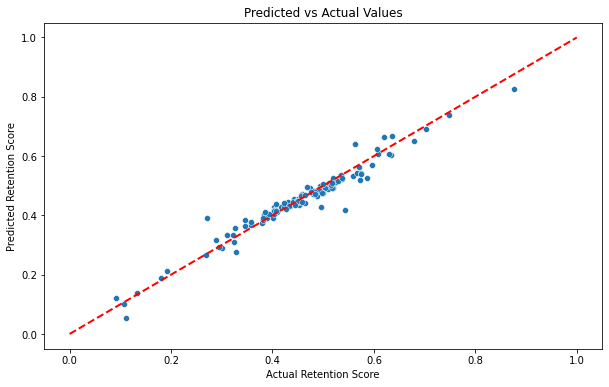

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = best_model.predict([X_test_text, X_test_combined]).flatten()

# Create a DataFrame for visualization
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df)
plt.title('Predicted vs Actual Values for Advanced Neural Network')
plt.xlabel('Actual Retention Score')
plt.ylabel('Predicted Retention Score')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line for reference (Perfect Prediction)
plt.show()

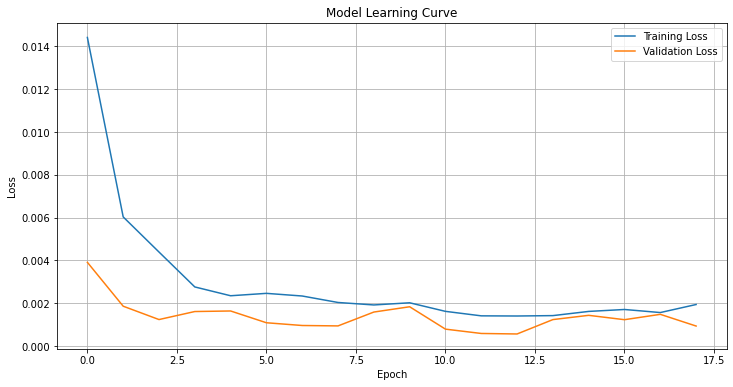

In [6]:
# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


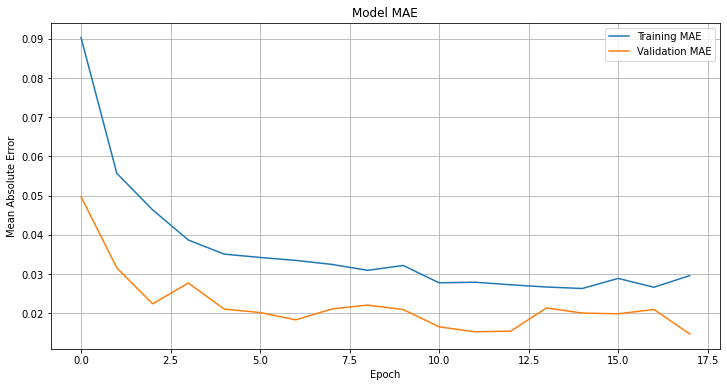

In [7]:
# Plotting Mean Absolute Error (MAE)
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Neural Network Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

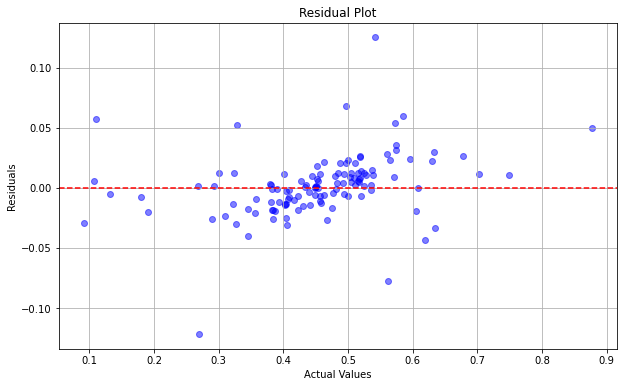

In [8]:
# Calculating residuals
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))

# Creating a scatter plot of actual vs. residuals
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.title('Residual Plot of Neural Network')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Adds a horizontal line at zero for reference
plt.grid(True)

# Show the plot
plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2000, 200)    868000      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          168448      ['embedding[0][0]']              
                                                                                              

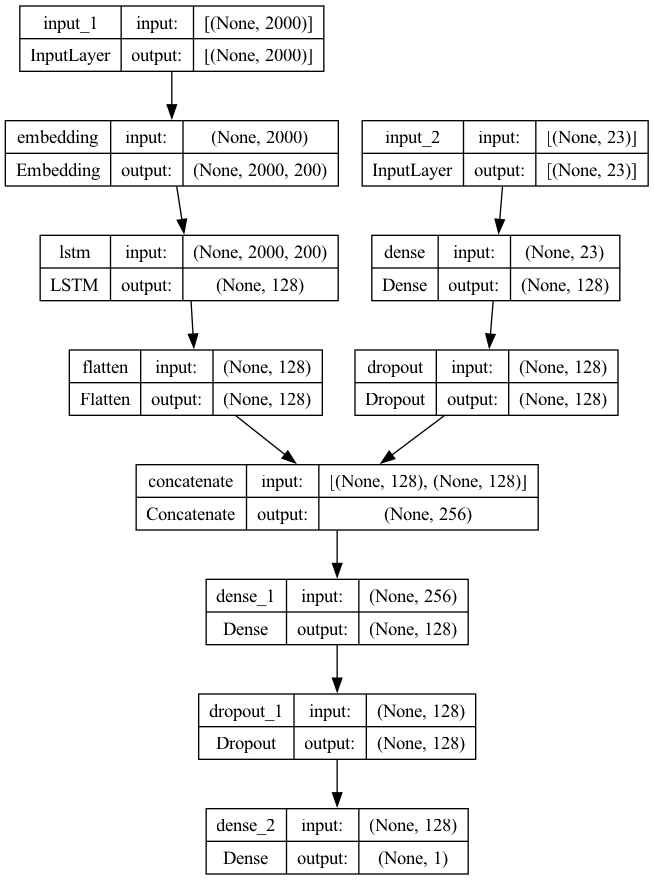

In [10]:
best_model.summary()
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(best_model, to_file='images/best_model_visualization.png', show_shapes=True, show_layer_names=True)

In [11]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_combined):
    X_train_combined, X_test_combined = X_combined[train_index], X_combined[test_index]
    X_train_text, X_test_text = review_padded[train_index], review_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Neural Network Architecture with Sigmoid Output Layer
    input_text = Input(shape=(max_review_length,))
    input_combined = Input(shape=(X_train_combined.shape[1],))

    # Text branch
    text_branch = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_text)
    text_branch = LSTM(128)(text_branch)  # Consider reducing if overfitting is observed
    text_branch = Flatten()(text_branch)

    # Combined branch with Dropout
    combined_branch = Dense(128, activation='relu')(input_combined)
    combined_branch = Dropout(0.3)(combined_branch)  # Adjust if necessary

    # Concatenate branches
    concat = Concatenate()([text_branch, combined_branch])
    dense = Dense(128, activation='relu')(concat)
    dense = Dropout(0.3)(dense)  # Adjust if necessary
    output = Dense(1, activation='sigmoid')(dense)  # Sigmoid activation for output

    # Compile the model
    optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
    model = Model(inputs=[input_text, input_combined], outputs=output)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    # Early Stopping and Model Checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

    # Train the model with a simpler architecture
    model.fit([X_train_text, X_train_combined], y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])
    
    # Load and evaluate the best model
    best_model = load_model('best_model.h5')
    
    # Evaluate the model
    y_pred = best_model.predict([X_test_text, X_test_combined])
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)
    

# Calculate average scores
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print(f"Average Mean Squared Error: {average_mse}")
print(f"Average R-squared: {average_r2}")

Epoch 1/20
13/13 [==============================] - 24s 2s/step - loss: 0.0102 - mae: 0.0728 - val_loss: 0.0120 - val_mae: 0.0915
Epoch 2/20
13/13 [==============================] - 20s 2s/step - loss: 0.0052 - mae: 0.0511 - val_loss: 0.0104 - val_mae: 0.0834
Epoch 3/20
13/13 [==============================] - 20s 2s/step - loss: 0.0030 - mae: 0.0412 - val_loss: 0.0111 - val_mae: 0.0877
Epoch 4/20
13/13 [==============================] - 20s 2s/step - loss: 0.0028 - mae: 0.0370 - val_loss: 0.0082 - val_mae: 0.0758
Epoch 5/20
13/13 [==============================] - 19s 1s/step - loss: 0.0020 - mae: 0.0333 - val_loss: 0.0105 - val_mae: 0.0855
Epoch 6/20
13/13 [==============================] - 21s 2s/step - loss: 0.0018 - mae: 0.0312 - val_loss: 0.0109 - val_mae: 0.0874
Epoch 7/20
13/13 [==============================] - 21s 2s/step - loss: 0.0018 - mae: 0.0298 - val_loss: 0.0113 - val_mae: 0.0900
Epoch 8/20
13/13 [==============================] - 20s 2s/step - loss: 0.0015 - mae: 0.02